In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import datetime                                  # manipulating date formats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA


#SARIMAX function can fit all the models in the family
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import sklearn.metrics as skmetrics
from statsmodels.tsa.stattools import arma_order_select_ic
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import pmdarima as pm

%matplotlib inline

# 1. EDA

In [2]:
######### 1. Time series plot
# EXAMPLE 1: confirmed covid cases in sf

df = pd.read_csv('zillow-carlifornia.csv')
df_test = pd.read_csv('test.csv')
df.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [3]:
df_predict =df[df['MedianSoldPrice_AllHomes.California'].isnull()]
df_train = df[~df['MedianSoldPrice_AllHomes.California'].isnull()]

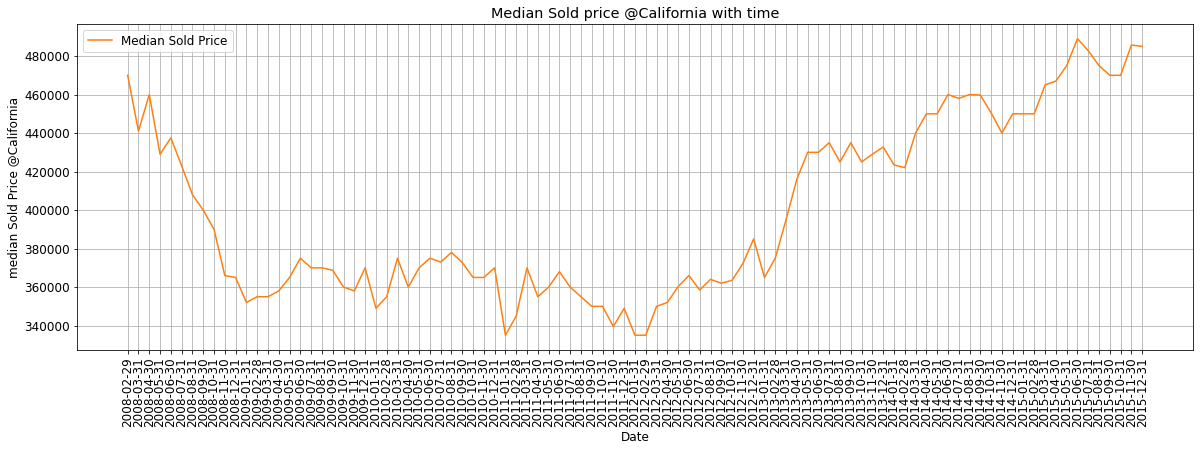

In [4]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_train.Date, df_train['MedianSoldPrice_AllHomes.California'], color='tab:orange', label='Median Sold Price')
#ax.plot(df_train.Date, df_train['UnemploymentRate'], color='tab:red', label='Unemployment Rate')
#ax.plot(df_train.Date, df_train['MedianMortageRate'], color='tab:blue', label='Median Mortgage Rate')
# Same as above

ax.set_xlabel('Date')
ax.set_ylabel('median Sold Price @California')
ax.set_title('Median Sold price @California with time')
ax.grid(True)
plt.xticks(rotation=90)
ax.legend(loc='upper left');


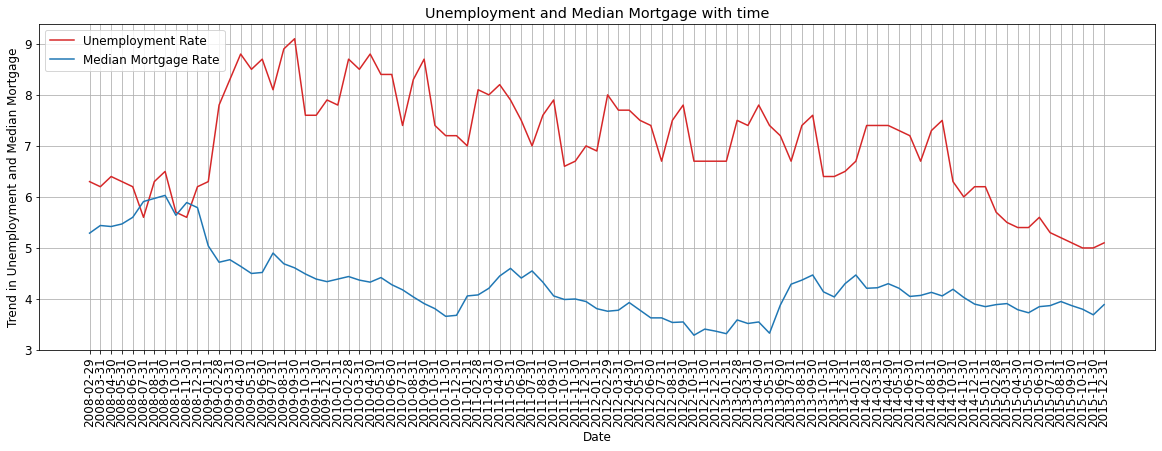

In [5]:

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
#ax.plot(df_train.Date, df_train['MedianSoldPrice_AllHomes.California'], color='tab:orange', label='Median Sold Price')
ax.plot(df_train.Date, df_train['UnemploymentRate'], color='tab:red', label='Unemployment Rate')
ax.plot(df_train.Date, df_train['MedianMortageRate'], color='tab:blue', label='Median Mortgage Rate')
# Same as above

ax.set_xlabel('Date')
ax.set_ylabel('Trend in Unemployment and Median Mortgage')
ax.set_title('Unemployment and Median Mortgage with time')
ax.grid(True)
plt.xticks(rotation=90)
ax.legend(loc='upper left')
plt.show()


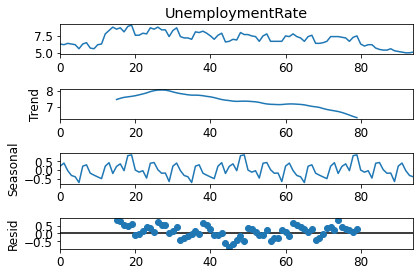

In [6]:
#classical decomposition
#addictive
res = sm.tsa.seasonal_decompose(df_train['UnemploymentRate'],period=30,model="addictive")
fig = res.plot()

# 2. Model Selection
## 2.1 Arima Model

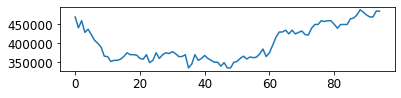

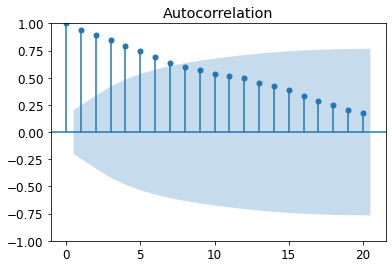

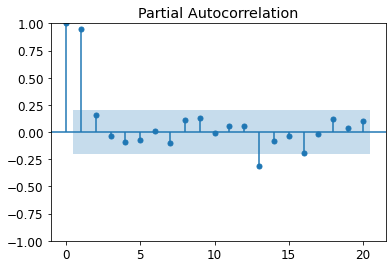

In [7]:
#use this data to perform an ARMA model estimation
#1. Plots
plt.subplot(3,1,1)
plt.plot(df_train['MedianSoldPrice_AllHomes.California'])
plt.show()
plot_acf(df_train['MedianSoldPrice_AllHomes.California'],lags=20)
plt.show()
plot_pacf(df_train['MedianSoldPrice_AllHomes.California'],lags=20)
plt.show()
#looks stationary, but hard to tell if it's AR or MA, maybe fit an ARMA(p,q)

In [8]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

In [9]:
adf_test(df_train['MedianSoldPrice_AllHomes.California'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -0.058792
p-value                         0.953391
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [10]:
d1 = diff(df_train['MedianSoldPrice_AllHomes.California'])
adf_test(d1)

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -3.088139
p-value                         0.027443
#Lags Used                     11.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [11]:
arma_order_select_ic(d1,max_ar=4, max_ma=4, ic='bic')

/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


{'bic':              0            1            2            3            4
 0  2368.033099  2037.580859  2038.935560  2040.152390  2043.983662
 1  2036.430577  2042.279609  2041.097931  2044.891762  2048.614871
 2  2040.757781  2044.213918  2039.193296  2045.078675  2045.215143
 3  2038.515807  2043.154544  2044.298236  2046.913875  2051.067269
 4  2043.203555  2048.148503  2045.987340  2051.587438  2050.496808,
 'bic_min_order': (1, 0)}

By the search, we have our **first Arima Candidate（1，1，0)**

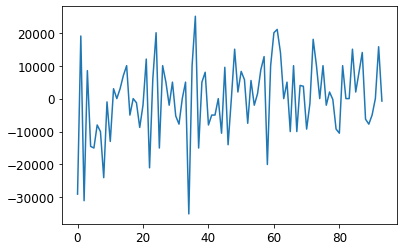

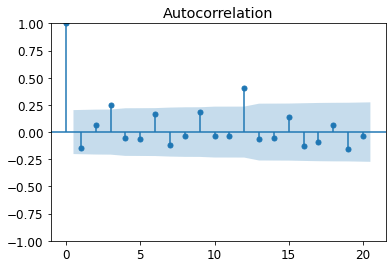

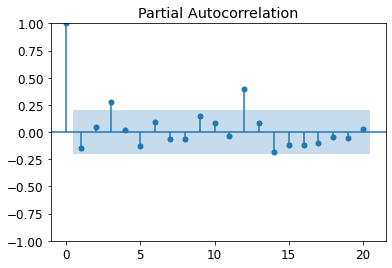

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


In [12]:
plt.plot(d1)
plot_acf(d1,lags=20) 
plt.show()
plot_pacf(d1,lags=20) 
plt.show()
dftest = adfuller(d1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

From the ACF and PACF plot we have from the d1 data, we see they all shut off at value 1. So our **Second Arima Candidate Model is (0,1,0)**

In [13]:
d2 = diff(df_train['MedianSoldPrice_AllHomes.California'],2)
adf_test(d2)

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -3.374527
p-value                         0.011859
#Lags Used                     10.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [14]:
arma_order_select_ic(d2,max_ar=4, max_ma=4, ic='bic') 

/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


{'bic':              0            1            2            3            4
 0  2388.508220  2018.283296  2021.763648  2024.502806  2023.131952
 1  2041.646705  2021.608315  2026.139310  2026.550123  2026.761039
 2  2045.237862  2027.230020  2028.176111  2025.758892  2030.833877
 3  2038.561185  2024.149174  2025.209587  2026.658059  2029.433251
 4  2031.623814  2025.300258  2029.710216  2029.976045  2033.850047,
 'bic_min_order': (0, 1)}

Though the p-value in the ADF test with d1 data shows it is stationary, we still want to see if it will be more stationary if we difference it again. The p-value of ADF test with d2 data is slightly smaller than the one from d1 data, so we also conduct an order search with d = 2.
There comes our **Third ARIMA Candidate order: (0,2,1).**

In [15]:
def mean_absolute_percentage_error(test, prediction):
     return np.mean(np.abs(test-prediction)/test)

def evaluate_sarima_model(X, trend_order, seasonal_order, split):
    train_size = int(len(X) * split)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit(disp = -1)
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    return rmse, mae, mape

In [16]:
#Arima Model evaluation
Arima_candidates = [(1,1,0),(0,1,0),(0,2,1)]
seasonal_order = (0,0,0,0)
Arima_Result = []
for can in Arima_candidates:
    rmse,mae,mape = evaluate_sarima_model(df_train['MedianSoldPrice_AllHomes.California'],can,seasonal_order,0.8)
    Arima_Result.append(('ARIMA',can,rmse,mae,mape))
for result in Arima_Result:
    print(result)

('ARIMA', (1, 1, 0), 8230.733743798248, 6302.596607455285, 0.013486125816777666)
('ARIMA', (0, 1, 0), 8161.607813737632, 6236.8421052631575, 0.013342107880215302)
('ARIMA', (0, 2, 1), 10323.72412491208, 8492.49955371944, 0.018157316017598957)


## 2.2 SARIMA 

In [17]:
def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit(disp = -1)
                                    bic=res.bic
                                    if bic < best_score:
                                        best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                except:
                                    continue
    print((best_score, best_order, best_seasonal_order))
    

In [18]:
p = range(0,3)
q = range(0,3)
d = range(0,3)
P = range(0,3)
Q = range(0,3)
D = 1
m = 12
bic_sarima(df_train['MedianSoldPrice_AllHomes.California'],p, d,q,P, Q,m,D )

/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/User

/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/User

(19.944920232821374, (0, 2, 2), (0, 1, 2, 12))


/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [19]:
model = pm.auto_arima(df_train['MedianSoldPrice_AllHomes.California'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # seasonal lag
                      d=None,           # let model determine 'd'
                      seasonal=True,   
                      information_criterion = 'bic',
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(model.summary())

 ARIMA(0,2,0)(0,1,0)[12]             : BIC=1813.873, Time=0.01 sec
 ARIMA(0,2,0)(0,1,1)[12]             : BIC=1820.160, Time=0.05 sec
 ARIMA(0,2,0)(0,1,2)[12]             : BIC=1835.006, Time=0.15 sec
 ARIMA(0,2,0)(0,1,3)[12]             : BIC=1821.937, Time=0.53 sec
 ARIMA(0,2,0)(1,1,0)[12]             : BIC=1816.972, Time=0.12 sec
 ARIMA(0,2,0)(1,1,1)[12]             : BIC=inf, Time=0.28 sec
 ARIMA(0,2,0)(1,1,2)[12]             : BIC=1911.904, Time=0.45 sec
 ARIMA(0,2,0)(1,1,3)[12]             : BIC=1824.794, Time=1.09 sec
 ARIMA(0,2,0)(2,1,0)[12]             : BIC=1827.108, Time=0.24 sec
 ARIMA(0,2,0)(2,1,1)[12]             : BIC=1830.705, Time=0.38 sec
 ARIMA(0,2,0)(2,1,2)[12]             : BIC=inf, Time=1.23 sec
 ARIMA(0,2,0)(2,1,3)[12]             : BIC=inf, Time=2.21 sec
 ARIMA(0,2,0)(3,1,0)[12]             : BIC=1834.527, Time=0.35 sec
 ARIMA(0,2,0)(3,1,1)[12]             : BIC=1835.518, Time=1.01 sec
 ARIMA(0,2,0)(3,1,2)[12]             : BIC=inf, Time=2.14 sec
 ARIMA(0,2,1)(0

In [20]:
#Sarima Model evaluation
Sarima_candidates = [((0,2,2), (1, 1, 2, 12)),((1,2,0), (0, 1, 0, 12))]
Sarima_results = []
for trend,seasonal in Sarima_candidates:
    rmse,mae,mape = evaluate_sarima_model(df_train['MedianSoldPrice_AllHomes.California'],trend, seasonal,0.8)
    Sarima_results.append(('SARIMA',(trend,seasonal),rmse,mae,mape))
for result in Sarima_results:
    print(result)


/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/User

('SARIMA', ((0, 2, 2), (1, 1, 2, 12)), 12300.822341552835, 9592.595957332962, 0.020515302460976836)
('SARIMA', ((1, 2, 0), (0, 1, 0, 12)), 15094.5049380997, 12837.48584495108, 0.027566722994199294)


/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


We allowed our sarima order search functions to find the number of times to difference the data, so the input data here is the original. 

Based on bic_sarima() it gave us our **first SARIMA candidate with order (0,2,2)(1,1,2,12)**. 

Based on pm.auto_sarima() it gave us our **second SARIMA candidate with order (1,2,0)(0,1,0,12)**.

## 2.3 Exponential Smoothing

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [22]:
def evaluate_exponential_model(X, trend, seasonal ):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in range(len(test)):
        #model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model = ExponentialSmoothing(X[:train_size+t], trend= trend, seasonal=seasonal, seasonal_periods=12)
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)  
    test = np.asanyarray(test).reshape(-1,)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mae = skmetrics.mean_absolute_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    return rmse, mae, mape

In [23]:
combinations = [(a,b) for a in ("add","mul") for b in ("add","mul",None)]
ETS_results = []

for seasonal, trend in combinations:
    rmse,mae,mape = evaluate_exponential_model(df_train['MedianSoldPrice_AllHomes.California'],trend, seasonal)
    ETS_results.append(('ETS',(trend,seasonal),rmse,mae,mape))
for result in ETS_results:
    print(result)    


/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.

/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.

('ETS', ('add', 'add'), 7868.554598679729, 5455.136839203019, 0.011710254404227982)
('ETS', ('mul', 'add'), 7807.0895979219895, 5501.414663419513, 0.011810695278096845)
('ETS', (None, 'add'), 8338.035510164995, 5750.057683217376, 0.012274398106777454)
('ETS', ('add', 'mul'), 127829.41185140514, 34930.764039778034, 0.07863808282237833)
('ETS', ('mul', 'mul'), 395331.7803073418, 116472.7159681035, 0.2583814119990373)
('ETS', (None, 'mul'), 115952.1166217566, 32076.344959619564, 0.07212554372329755)


/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/dchant/opt/anaconda3/lib/python3.

There are a total of **six candidate ETS models**, one for each combination of trend and seasonality. 

## 2.4 SARIMAX

In [24]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

In [25]:
train_ = df_train.set_index('Date')
train_sc = sc.fit_transform(train_)
#test_new = test.set_index('Date')

In [26]:
#auto sarimax search without seasonality
from pmdarima.arima import auto_arima

model = pm.auto_arima(train_sc[:,0],
                      exogenous= train_sc[:,2].reshape(-1,1), 
                      start_p=0, start_q=0,      
                      max_p=4, max_q=4, 
                      m=12,              
                      max_d=2, 
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      D=1, 
                      test='adf', 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-193.583, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-194.969, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-195.211, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-194.196, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-194.460, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-195.537, Time=0.95 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-194.436, Time=2.24 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=-194.342, Time=3.07 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=-192.523, Time=2.43 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-195.083, Time=0.62 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-195.940, Time=1.04 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-195.414, Time=0.39 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-195.672, Time=1.21 sec
 ARIMA(1,1,1)(0,1,3)[12]             : AIC=-195.012, Time=2.20 sec
 ARIMA(1,1,1)(1,1,1

**cross validation**

In [62]:
def evaluate_sarimax_model(X, trend_order, seasonal_order, split, exog):
    train_size = int(len(X) * split)
    train, test = X[0:train_size], X[train_size:]
    X_new = X.set_index('Date')
    
    predictions = list()
    for t in tqdm(range(len(test))):
        training =X_new[:train_size+t]
        testing = X_new[train_size+t:]
        sc = MinMaxScaler(feature_range=(0, 1))
        train_sc = sc.fit_transform(training)
        test_sc = sc.transform(testing)
        model = sm.tsa.statespace.SARIMAX(train_sc[:,0], order=trend_order,seasonal_order=seasonal_order, exog=train_sc[:,exog].reshape(-1,1)) #rolling forward for one step at each time
        model_fit = model.fit(disp=False)
        #y_pred =model_fit.predict(start=len(train_sc[:,0])+1, end=len(train_sc[:,0]) + 2, exog=test_sc[0,exog])
        y_pred =model_fit.forecast(1, exog=test_sc[0,exog])
        y_pred_ =  np.repeat(y_pred,3,axis=0)
        y_pred_inv = sc.inverse_transform(y_pred_.reshape(1,3))[:,0]
        predictions.append(y_pred_inv) #store prediction
    
    print("Validation_done")
    predictions = np.asarray(predictions).reshape(-1,)
    test_y = np.asanyarray(test['MedianSoldPrice_AllHomes.California'].values).reshape(-1,)
    rmse = np.sqrt(skmetrics.mean_squared_error(test_y, predictions))
    mae = skmetrics.mean_absolute_error(test_y, predictions)
    mape = mean_absolute_percentage_error(test_y, predictions)
    return rmse, mae, mape

In [63]:
rmse,mae,mape = evaluate_sarimax_model(df_train,(4,1,0), (0,1,2, 12), 0.80, 2)

  0%|                                                    | 0/19 [00:00<?, ?it/s]/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  5%|██▎                                         | 1/19 [00:01<00:22,  1.25s/it]/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 11%|████▋                                       | 2/19 [00:02<00:19,  1.13s/it]/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 16%|██████▉                                     | 3/19 [00:03<00:17,  1.12s/it]/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:6

Validation_done


In [64]:
Sarimax_results=[('SARIMAX',((4,1,0), (0,1,2,12)),rmse,mae,mape)]
print(Sarimax_results[0])

('SARIMAX', ((4, 1, 0), (0, 1, 2, 12)), 10486.681702772732, 7629.202124825804, 0.016448813787229073)


Based on auto_arima() it suggested a **SARIMAX model with order (0,1,4)(0,1,2,12)**. We then put this model into a function that performed cross validation to find the rmse, mae, mape scores. 

## Final Results

In [65]:
results = Arima_Result+Sarima_results+ETS_results+Sarimax_results

In [66]:
df_result = pd.DataFrame(results, columns=['Model','Order','RMSE','MAE','MAPE'])

In [67]:
df_result

,Model,Order,RMSE,MAE,MAPE
0,ARIMA,"(1, 1, 0)",8230.733744,6302.596607,0.013486
1,ARIMA,"(0, 1, 0)",8161.607814,6236.842105,0.013342
2,ARIMA,"(0, 2, 1)",10323.724125,8492.499554,0.018157
3,SARIMA,"((0, 2, 2), (1, 1, 2, 12))",12300.822342,9592.595957,0.020515
4,SARIMA,"((1, 2, 0), (0, 1, 0, 12))",15094.504938,12837.485845,0.027567
5,ETS,"(add, add)",7868.554599,5455.136839,0.011710
6,ETS,"(mul, add)",7807.089598,5501.414663,0.011811
7,ETS,"(None, add)",8338.035510,5750.057683,0.012274
8,ETS,"(add, mul)",127829.411851,34930.764040,0.078638
9,ETS,"(mul, mul)",395331.780307,116472.715968,0.258381


Based on these results, an **ETS model with additive trend and seasonality** is our best model.

# Final Model Forecast

In [55]:
train = df_train[['Date', 'MedianSoldPrice_AllHomes.California']].copy()
train['Date'] = pd.to_datetime(train['Date'])
train = train.set_index('Date')

test = df_test.copy()
test['Date'] = pd.to_datetime(test['Month'])
test = test.set_index('Date').drop('Month', axis = 1)

/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/dchant/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


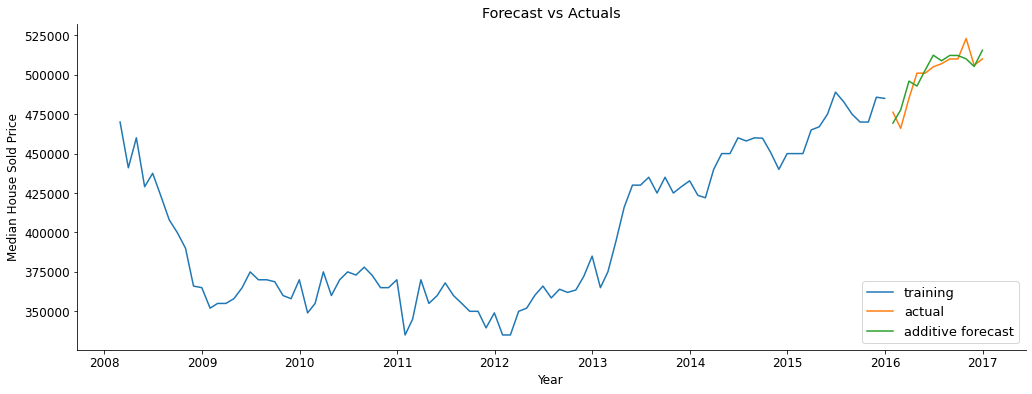

In [74]:
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
fitted = ets_model.fit() #fit the model on train set
pred = fitted.forecast(len(test))

fig, ax = plt.subplots(figsize = (17,6))
ax.plot(train['MedianSoldPrice_AllHomes.California'], label='training')
ax.plot(test, label='actual')
ax.plot(pred, label='additive forecast')

ax.set_ylabel('Median House Sold Price')
ax.set_xlabel('Year')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(loc='lower right', fontsize=13)
plt.title('Forecast vs Actuals')
plt.show()

In [58]:
rmse = np.sqrt(skmetrics.mean_squared_error(test, pred))
print(rmse)

7307.862033152962
